In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Importing the RNN class and task dataset implementation
from train_rnn import MyRNN, train, simulate_with_lesions
from rnntaskdataset import RNNTaskDataset

# Define the hyperparameter search space
hidden_dims = [32, 64, 128, 256]
initialization_types = ['random']
g_values = [0.1, 0.5, 0.9]
nonlinearities = ['tanh','relu']
tasks = ['ready_set_go', 'delay_discrimination', 'flip_flop', 'integrator']
device='cpu'


import torch.nn as nn
class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Create a mask that is 1 where y_true is not nan and 0 where y_true is nan
        mask = ~torch.isnan(y_true)

        # Apply the mask to y_pred and y_true
        y_pred_masked = y_pred[mask]
        y_true_masked = y_true[mask]

        # Compute MSE only for non-nan values
        loss1 = nn.functional.mse_loss(y_pred_masked, y_true_masked)
        loss2 = torch.mean((y_pred_masked-y_true_masked)**2)
        std = torch.std((y_pred_masked-y_true_masked)**2)
        all_loss = (y_pred_masked-y_true_masked)**2
        
        return loss1, loss2, std, all_loss

criterion_fn = MaskedMSELoss()

In [2]:
plot = False
low = True
percentage_silenced=0.1

dic = {
    'hidden':[],
    'g':[],
    'phi':[],
    'task':[],

    'connectivity_std':[],
    'activity_std':[],
    
    'mse_control':[],
    'std_control':[],

    'mse_lesion_connectivity':[],
    'std_lesion_connectivity':[],

    'mse_lesion_activity':[],
    'std_lesion_activity':[],

}

In [4]:
for hidden_dim in hidden_dims:
        for init_type in initialization_types:
            for g in g_values:
                for nonlinearity in nonlinearities:
                    for task in tasks:

                        dic['hidden'].append(hidden_dim)
                        dic['g'].append(g)
                        dic['phi'].append(nonlinearity)
                        dic['task'].append(task.split('_')[-1])
                        
                        task_dataset = RNNTaskDataset(n_trials=100, time=100, n_channels=2)
                        x, y = getattr(task_dataset, task)()  # Get the input and target outputs for the task
                        x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
                        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
                        
                        model = MyRNN(input_dim=x.shape[2], 
                                      hidden_dim=hidden_dim, 
                                      output_dim=y.shape[2],
                                      nonlinearity=nonlinearity, 
                                      initialize_uniform=(init_type == "uniform"),
                                      initialize_normal=(init_type == "random"), g=g).to(device)
                        
                        weights_path = os.path.join('rnn_weights_2/', f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
                        
                        
                        # Load weights if they exist
                        if os.path.exists(weights_path):
                            model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))

                        else:
                            weights_path = os.path.join('rnn_weights_2/', f"best_failed_weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
                            model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))

                        if plot:
                            fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))
                        weight_matrix = model.rnn.bias_hh_l0.detach().numpy()  # Example for accessing layer weights
                        dic['connectivity_std'].append(weight_matrix.std())
                        
                        if plot:
                            ax2.set_title(f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}")
                            sns.histplot(ax=ax2,data=weight_matrix)
                            ax2.set_xlabel('connectivity')
                        
                        num_silenced = int(hidden_dim * percentage_silenced)

                        if low: 
                            ko_neurons_connectivity = np.argsort(np.abs(weight_matrix))[:num_silenced] # find neurons with low connectivity
                        else:
                            ko_neurons_connectivity = np.argsort(np.abs(weight_matrix))[::-1][:num_silenced] # find neurons with high connectivity
                        
                        all_output = [] 
                        all_hidden = [] 
                        hid = None
                        for i in range(x.shape[1]):
                            out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid)
                            all_output.append(out)
                            all_hidden.append(hid)
                            
                        if plot:
                            sns.histplot(ax=ax3,data=torch.stack(all_hidden).flatten().detach().numpy())
                            ax3.set_xlabel('activity')
                        dic['activity_std'].append(torch.stack(all_hidden).flatten().detach().numpy().std())

                        if low: 
                        # find neurons with low activity
                            ko_neurons_activity = torch.argsort(torch.stack(all_hidden).squeeze().mean(axis=0).mean(axis=0)).detach().numpy()[:num_silenced]
                        else:
                            ko_neurons_activity = torch.argsort(torch.stack(all_hidden).squeeze().mean(axis=0).mean(axis=0)).detach().numpy()[::-1][:num_silenced]
    
                        # sim comtrol 
                        all_output = [] 
                        all_hidden = [] 
                        hid = None
                        for i in range(x.shape[1]):
                            out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid)
                            all_output.append(out)
                            all_hidden.append(hid)
                        
                        control_mean_mse, check, control_std_mse,control_raw = criterion_fn(torch.stack(all_output).squeeze().mT.reshape(100,100,y_tensor.size(2)),y_tensor)

                        assert control_mean_mse==check

                        dic['mse_control'].append(check.item())
                        dic['std_control'].append(control_std_mse.item())
                        
                        # sim ko connectivity 
                        all_output = [] 
                        all_hidden = [] 
                        hid = None
                        for i in range(x.shape[1]):
                            out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid)
                            for neuron_idx in ko_neurons_connectivity:
                                hid[0,:,neuron_idx] = 0  # Zero out targeted neurons in the hidden state
                            all_output.append(out)
                            all_hidden.append(hid)
                            
                        connectivity_mean_mse, check, connectivity_std_mse, connectivity_raw = criterion_fn(torch.stack(all_output).squeeze().mT.reshape(100,100,y_tensor.size(2)),y_tensor)
                        assert connectivity_mean_mse==check
                        dic['mse_lesion_connectivity'].append(check.item())
                        dic['std_lesion_connectivity'].append(connectivity_std_mse.item())
                        
                        # sim ko activity
                        all_output = [] 
                        all_hidden = [] 
                        hid = None
                        for i in range(x.shape[1]):
                            out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid)
                            for neuron_idx in ko_neurons_activity:
                                hid[0,:,neuron_idx] = 0  # Zero out targeted neurons in the hidden state
                            all_output.append(out)
                            all_hidden.append(hid)
                            
                        activity_mean_mse, check, activity_std_mse, activity_raw = criterion_fn(torch.stack(all_output).squeeze().mT.reshape(100,100,y_tensor.size(2)),y_tensor)
                        assert activity_mean_mse==check
                        dic['mse_lesion_activity'].append(check.item())
                        dic['std_lesion_activity'].append(activity_std_mse.item())
                        
                        data = pd.DataFrame({'contol':control_raw.detach().numpy(),
                                      'connectivity':connectivity_raw.detach().numpy(),
                                      'activity':activity_raw.detach().numpy()})

                        if plot:
                        
                            sns.boxplot(ax=ax1, data=data,log_scale=True)
                            ax1.set_ylabel(f'$log(mse)$')
                        
                        
                            sns.despine()
                            plt.tight_layout()
                            plt.show()
                        
                                                            


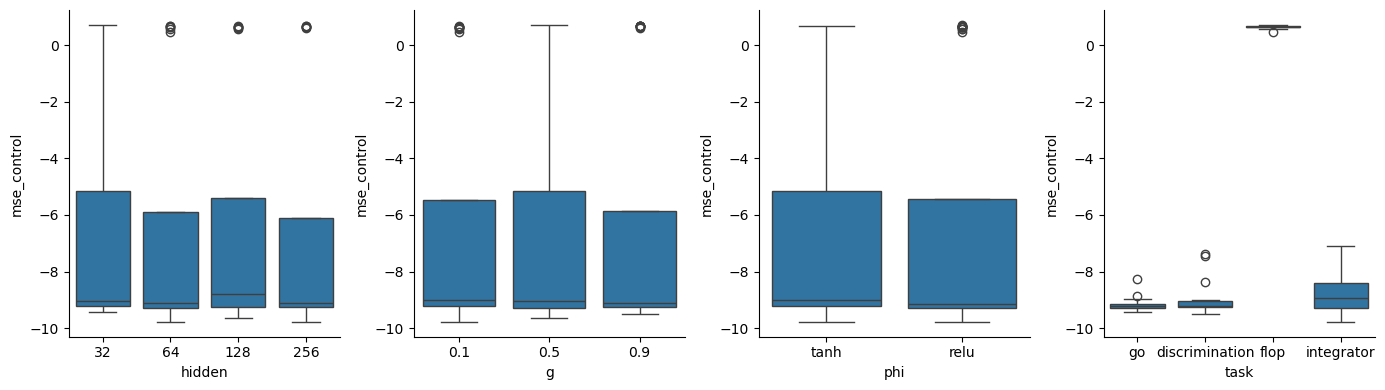

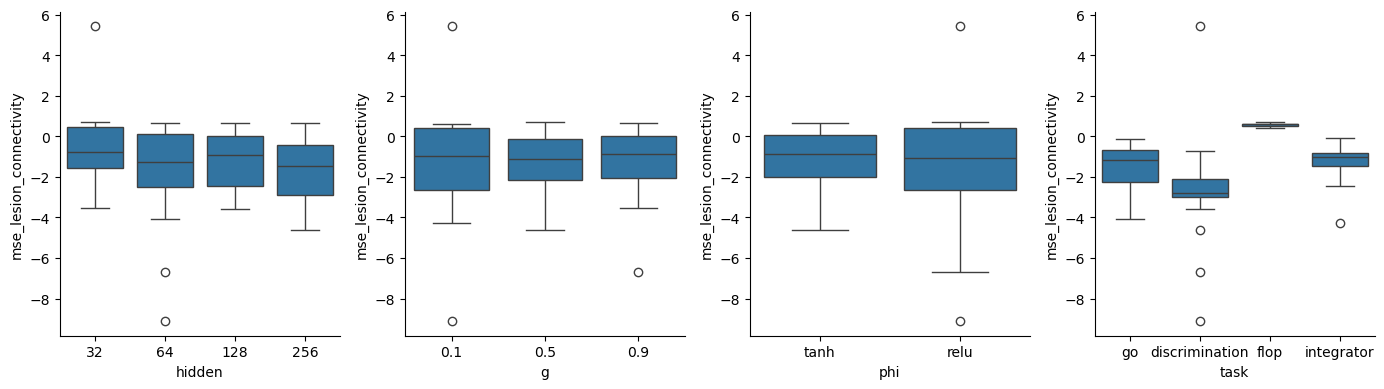

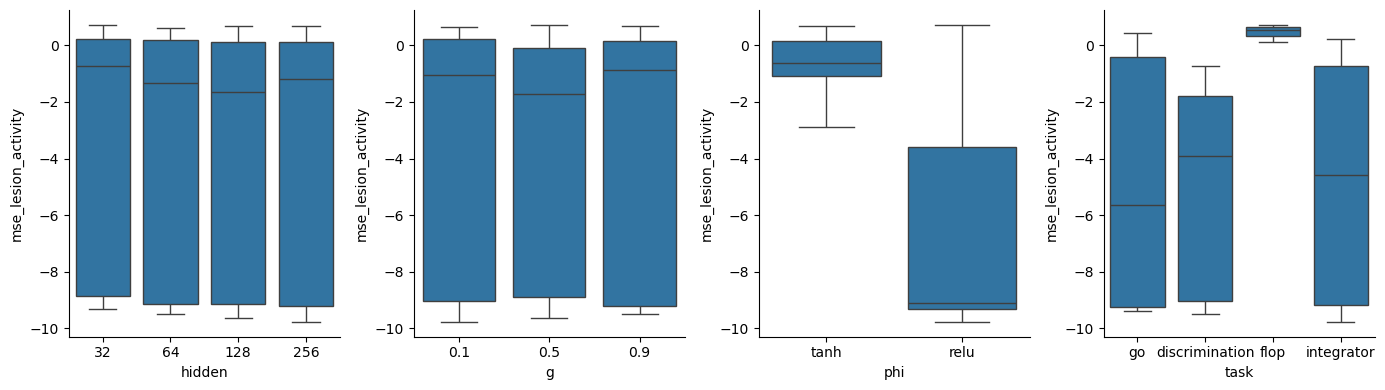

In [57]:
df = pd.DataFrame(dic)
df[['mse_control', 'std_control', 
    'mse_lesion_connectivity', 'std_lesion_connectivity',
    'mse_lesion_activity','std_lesion_activity']] = np.log(df[['mse_control', 'std_control', 
    'mse_lesion_connectivity', 'std_lesion_connectivity',
    'mse_lesion_activity','std_lesion_activity']])

fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='mse_control')

sns.despine()
plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='mse_lesion_connectivity')

sns.despine()
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='mse_lesion_activity')

sns.despine()
plt.tight_layout()
plt.show()

df['phi'] = df['phi'].astype("category")
df['task'] = df['task'].astype("category")

# df['phi'] = df['phi'].cat.codes
# df['task'] = df['task'].cat.codes
                                              

,hidden,g,phi,task,connectivity_std,activity_std,mse_control,std_control,mse_lesion_connectivity,std_lesion_connectivity,mse_lesion_activity,std_lesion_activity
0,32,0.1,tanh,go,0.105030,0.709815,-9.211590,-7.623725,-1.020743,-0.724313,0.165338,0.176962
1,32,0.1,tanh,discrimination,0.085931,0.770968,-9.206354,-7.525670,-1.988590,-1.366588,-1.001633,-0.514116
3,32,0.1,tanh,integrator,0.087740,0.160443,-7.995099,-6.411037,-0.829523,-0.192947,-0.698507,-0.060052
4,32,0.1,relu,go,0.165422,2.560390,-9.218037,-7.618599,-1.240668,-0.687129,-9.218037,-7.618599
5,32,0.1,relu,discrimination,0.147936,1.524812,-7.438814,-5.623563,5.426971,7.004969,-7.438814,-5.623563
...,...,...,...,...,...,...,...,...,...,...,...,...
89,256,0.9,tanh,discrimination,0.040887,0.841131,-9.081242,-6.451558,-2.865999,-1.436399,-1.173924,-0.788962
91,256,0.9,tanh,integrator,0.069148,0.976794,-9.020661,-7.706101,-1.098487,-0.619858,0.215948,0.713928
92,256,0.9,relu,go,0.043566,0.165674,-9.394211,-7.680470,-2.253923,-1.510392,-9.394211,-7.680470
93,256,0.9,relu,discrimination,0.045572,0.280116,-9.513134,-7.634197,-2.931429,-1.378688,-9.513134,-7.634197


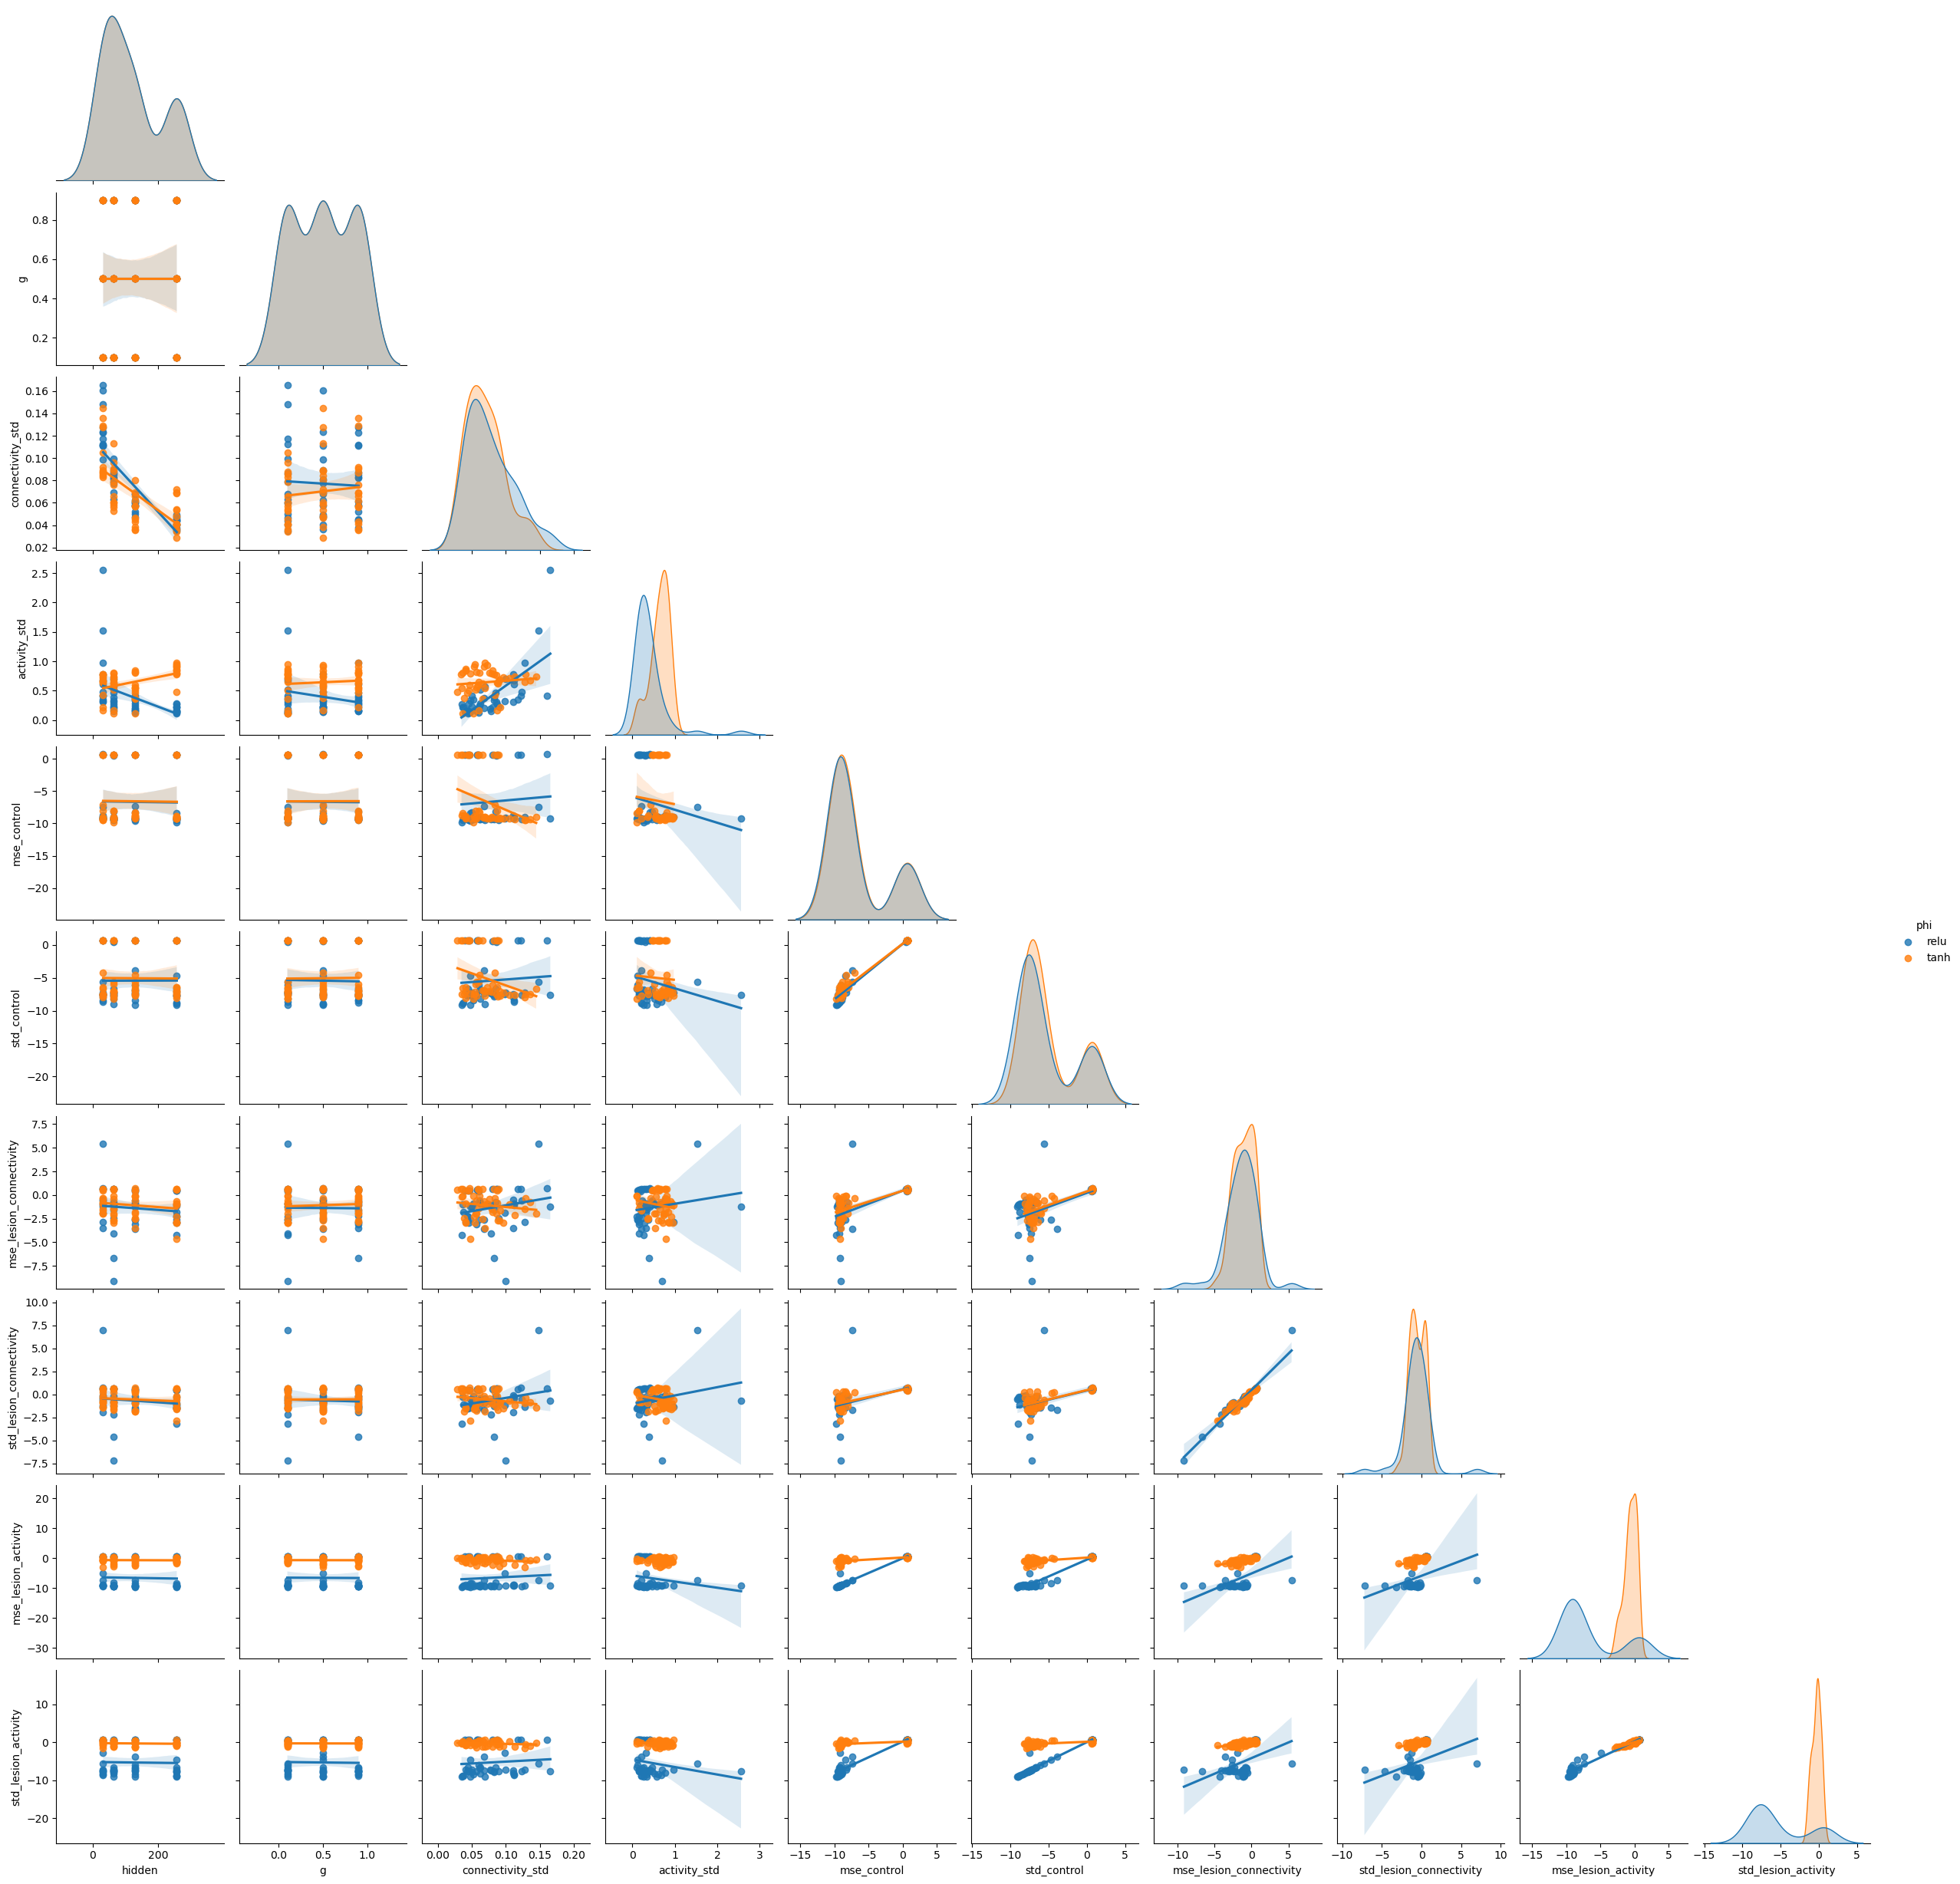

In [63]:
sns.pairplot(df, corner=True, kind='reg', hue='phi', palette='tab10') # reg 

In [ ]:
# neurons to silence randomly
##############################
# percentage_silenced = 0.1  # 10% of neurons to silence randomly
# num_silenced = int(hidden_dim * percentage_silenced)
# ko_neurons = np.random.choice(hidden_dim, num_silenced, replace=False)
##############################

# find neurons with high connectivity
##############################
# connectivity_threshold = 0.169 # Example threshold for high connectivity
# weight_matrix = model.rnn.bias_hh_l0.detach().numpy()  # Example for accessing layer weights
# ko_neurons = np.where(np.abs(weight_matrix)>connectivity_threshold)[0]
##############################